__First Assignment__ - Optimization for large-scale data - Francesca Sallicati 100341618

A company produces a set of products at I plants. It then ships these products to J market zones.
For $i = 1,...,I$ y $j = 1,...,J$, the following data are given:
$v_i$ = variable cost of producing one unit of product at plant $i$. <br>
$c_{ij}$ = cost of shipping one unit of product from plant $i$ to market $j$. <br>
$d_j$ = demand for products at market $j$. <br>
$M_i$ = maximum number or products produced at plant $i$. <br>
$p_j$ = selling price for products at market $j$. <br>
$F$ = maximum transportation capacity between plant $i$ and market $j$ (assume all transportation
capacities are equal). <br>

a) (3 points) Formulate the problem (linear program) of maximizing the total profit that the
company is facing (total selling revenue - total production and transportation costs) by
identifying the optimal production and transportation schedule. Assume also that demand
is satisfy with "equality", i.e., "total product reaching market $j$" = $d_j$ ).

__SOLUTION__

After defining 
$X_{ij}$ as the units produced in market $i$, shipped to and sold in market $j$.  

Our optimization problem consists in maximize the total profit, therefore the objective function will be:
$$ \max (\sum_{i=1}^{I}  \sum_{j=1}^{J} p_{j} X_{ij} - \sum_{i=1}^{I}  \sum_{j=1}^{J} v_{i} c_{ij} X_{ij})$$


while the constraints are:

-satisfying the demand for markets $j$

$$\displaystyle \sum_{i=1}^{I} X_{ij} = d_{j} \quad j=1,...,J \quad $$

-producing whithin capacity of plants $i$

$$\displaystyle \sum_{j=1}^{J} X_{ij} \le M_{i} \quad i=1,...,I \quad $$

-transporting less than maximum capacity of shipping from plant $i$ to market $j$

$$X_{ij} \le F \quad j=1,...,J \quad i=1,...,I \quad $$

-imposing positivity

$$X_{ij} \ge 0 \quad j=1,...,J \quad i=1,...,I \quad $$



b) (4 points) Implement the model in Pyomo as an "AbstractModel()" and solve it considering
5 plants and 6 markets and randomly generated parameters. For the random generation of
these parameters consider uniform distributions within the following ranges: $v_i \in [1:5; 2:5]$,
$c_{ij} \in [1; 2]$, $d_j \in [275; 325]$, $M_i \in [400; 900]$, $p_j \in [4; 5]$ y $F \in [250; 350]$.

In [2]:
#importing useful libraries and plot features
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp

from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

In [3]:
sp.random.seed(12345)
print("The randomly generated values for the variables are the following:")

n=5; #number of plants (i)
m=6; #number of markets

#production cost (1 unit) at plant i
cost = np.random.uniform(low=1.5,high=2.5, size=5)
print("Cost")
print(cost)

#demand at market j
demand = np.random.randint(low=275,high=325, size=6)
print("Demand")
print(demand)

#max production at plant i 
maxProd = np.random.randint(low=400,high=900, size=5)
print("Maximum Production")
print(maxProd)

#selling price at market j
price = np.random.uniform(low=4,high=5, size=6)
print("Price")
print(price)

#transportation cost from plant i to market j (1 unit)
ship = np.random.uniform(low=1,high=2, size=(5, 6))
print("Shipping cost")
print(ship)

#max transportation capacity (assuming equality) between plant i and market j
maxCap = np.random.randint(low=250,high=350, size=(5, 6))
print("Maximum Transportation Capacity")
print(maxCap)


The randomly generated values for the variables are the following:
Cost
[ 2.42961609  1.81637555  1.68391881  1.70456028  2.06772503]
Demand
[304 276 324 289 316 302]
Maximum Production
[647 774 608 770 601]
Price
[ 4.02678972  4.29150239  4.39874403  4.80728871  4.62709433  4.9079249 ]
Shipping cost
[[ 1.5563973   1.83991925  1.05048796  1.80623485  1.93081569  1.36402958]
 [ 1.69094792  1.12931457  1.8326864   1.31835373  1.73720226  1.59676964]
 [ 1.36370684  1.79497057  1.69848115  1.82187893  1.89946589  1.8318993 ]
 [ 1.90995772  1.97491359  1.65611959  1.81198957  1.10274399  1.23752845]
 [ 1.37934521  1.69923605  1.48494525  1.41522223  1.63866181  1.75928999]]
Maximum Transportation Capacity
[[250 340 294 307 264 276]
 [293 280 349 282 253 314]
 [256 316 299 287 322 293]
 [312 336 271 315 346 255]
 [312 334 321 319 295 268]]


In [4]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

def trans_opt(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)

    
    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value

    return instance.OBJ(), x_sol



In [5]:
[obj,x_sol]=trans_opt(n,m,cost,ship,demand,maxProd,price,maxCap)

In [6]:
obj

2611.0831738318543

In [9]:
print(x_sol)

[[   0.    0.    0.    0.    0.    0.]
 [   0.  276.    0.  282.    0.   47.]
 [ 256.    0.  125.    0.    0.    0.]
 [   0.    0.  199.    0.  316.  255.]
 [  48.    0.    0.    7.    0.    0.]]


c) (1 point) Considering the results: which plant's maximum capacity would be more benecial
to increase? and in which market would be more benecial to increase the demand? Justify
your answers.

('Objective function value for increasing capacity in plant', 1, ' is ', 2611.0831738318543)
('Objective function value for increasing capacity in plant', 2, ' is ', 2611.4313918033517)
('Objective function value for increasing capacity in plant', 3, ' is ', 2611.4826184214376)
('Objective function value for increasing capacity in plant', 4, ' is ', 2611.53251020233)
('Objective function value for increasing capacity in plant', 5, ' is ', 2611.0831738318543)
('The most beneficial increasing of maximum capacity would be in  plant:', 4)


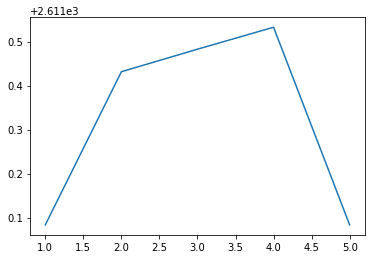

In [8]:
obj2 = 0
plant = -1
v_obj=np.zeros(n)

capacity = maxCap
for i in range(0, n):
    capacity[i] = capacity[i]+1
    if(i > 0):
        capacity[i-1] = capacity[i-1]-1
    obj,x_sol=trans_opt(n,m,cost,ship,demand,maxProd,price,maxCap)
    print("Objective function value for increasing capacity in plant", i + 1, " is ", obj)
    v_obj[i]=obj
    if obj2 < obj:
        obj2 = obj
        plant = i+1
         
print("The most beneficial increasing of maximum capacity would be in  plant:",plant)
plt.plot(range(1,n+1),v_obj)




('Objective function value for increasing capacity in plant', 1, ' is ', 2611.6628933132183)
('Objective function value for increasing capacity in plant', 2, ' is ', 2612.4289860947915)
('Objective function value for increasing capacity in plant', 3, ' is ', 2612.0995179049364)
('Objective function value for increasing capacity in plant', 4, ' is ', 2612.407515284465)
('Objective function value for increasing capacity in plant', 5, ' is ', 2612.8812438002506)
('Objective function value for increasing capacity in plant', 6, ' is ', 2612.577953534656)
('The most beneficial increasing of maximum capacity would be in  plant:', 5)


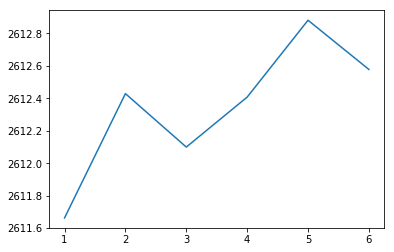

In [10]:
obj3 = 0
market = -1
v_obj2=np.zeros(m)

dem = demand
for i in range(0, m):
    dem[i] = dem[i]+1
    if(i > 0):
        dem[i-1] = dem[i-1]-1
    obj,x_sol=trans_opt(n,m,cost,ship,demand,maxProd,price,maxCap)
    print("Objective function value for increasing capacity in plant", i + 1, " is ", obj)
    v_obj2[i]=obj
    if obj3 < obj:
        obj3 = obj
        market = i+1
      
print("The most beneficial increasing of maximum capacity would be in  plant:", market)
plt.plot(range(1,m+1),v_obj2)

d) Modify the formulation in a) to impose that:
1. (1 point) Each plant is allowed to send its products to a maximum of 5 different markets <br>
2. (1 point) Plants, if operative, cannot produce less than 10% of their maximum capacity,
i.e., a plant can produce either 0 products (if not operative) or a quantity greater than
10% of its maximum capacity (if operative).

__SOLUTION 1__

By introducing the binary variable $Y_{ij}$ which takes value 1 if plant $i$ sends to market $j$ and 0 otherwise, we have to indroduce a new constraint:

$$ \sum_{j=1}^{J} Y_{ij} \le 5 \quad i=1,...,I \quad $$

In [11]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def trans_opt2(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)
    model.b = Var(model.I,model.J, within=Binary)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)
    
    #Binary representation maximum markets per plant
    def max_markets_constraint_rule(model, i): # return the expression to constrain the relation between i and j
        return sum(model.b[i,j] for j in model.J) <= 5
    
    model.max_markets_constraint_rule = Constraint(model.I, rule=max_markets_constraint_rule)
    
    #Limiting real numbers through binary model
    def bound_constraint_rule(model,i,j): 
        return model.x[i,j] <=  model.b[i,j]*M[i-1]
    
    model.bound_constraint_rule = Constraint(model.I,model.J,rule=bound_constraint_rule)

    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    s_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
                s_sol[i,j]=instance.b[i+1,j+1].value

    return instance.OBJ(), x_sol


In [12]:
obj2,x_sol2=trans_opt2(n,m,cost,ship,demand,maxProd,price,maxCap)

In [13]:
print("New Objective function values is:")
print(obj2)

New Objective function values is:
2612.57795353


In [14]:
print("while the previous was:")
print(obj)

while the previous was:
2612.57795353


In [15]:
print("New solutions are:")
print(x_sol2)

New solutions are:
[[   0.    0.    0.    0.    0.    0.]
 [   0.  276.    0.  282.    0.   48.]
 [ 256.    0.  125.    0.    0.    0.]
 [   0.    0.  199.    0.  316.  255.]
 [  48.    0.    0.    7.    0.    0.]]


In [16]:
print("while the original were:")
print(x_sol)

while the original were:
[[   0.    0.    0.    0.    0.    0.]
 [   0.  276.    0.  282.    0.   48.]
 [ 256.    0.  125.    0.    0.    0.]
 [   0.    0.  199.    0.  316.  255.]
 [  48.    0.    0.    7.    0.    0.]]


__SOLUTION 2__

By introducing the variable $O_i$ which takes the value of 1 if the plant $i$ is operative and 0 otherwise, let's add the constraint of producing at least 10% of its capacity:

$$\sum_{j=1}^{J} X_{ij} \ge 0.1 M_i O_i\quad i=1,...,I$$ 

In [17]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

def trans_opt3(I,J,v,c,d,M,p,F):

    model = AbstractModel()
    model.I = RangeSet(1,I) 
    model.J = RangeSet(1,J)
    model.b = Var(model.I,model.J, within=Binary)
    model.b2 = Var(model.I, within=Binary)

    # the next line declares a variable indexed by the set J 
    model.x = Var(model.I,model.J, domain=NonNegativeReals)

    #definition of the objective function
    def obj_expression(model): 
        return sum(sum(p[j-1]*model.x[i,j] for i in model.I) for j in model.J)-sum(sum(v[i-1]*model.x[i,j] for j in model.J) for i in model.I)-sum(sum(c[i-1,j-1]*model.x[i,j] for i in model.I) for j in model.J)
    
    model.OBJ = Objective(rule=obj_expression, sense=maximize)
    
    
    #maximum flow per line
    def flow_constraint_rule(model, i,j): # return the expression for the constraint for i
        return model.x[i,j] <= F[i-1,j-1]
    model.max_flow = Constraint(model.I,model.J, rule=flow_constraint_rule)

    #minimum demand constraint
    def d_constraint_rule(model, j): # return the expression for the constraint for i
        return sum(model.x[i,j] for i in model.I) == d[j-1]
    
    #the next line creates one constraint for each member of the set model.J 
    model.dem_Constraint = Constraint(model.J, rule=d_constraint_rule)

    #maximum production constraint
    def M_constraint_rule(model, i): # return the expression for the constraint for i
        return sum(model.x[i,j] for j in model.J)<= M[i-1]
    
    model.prod_Constraint = Constraint(model.I, rule=M_constraint_rule)
    
    #Binary representation maximum markets per plant
    def max_markets_constraint_rule(model, i): # return the expression to constrain the relation between i and j
        return sum(model.b[i,j] for j in model.J) <= 5
    
    model.max_markets_constraint_rule = Constraint(model.I, rule=max_markets_constraint_rule)
    
    #Limiting real numbers through binary model
    def bound_constraint_rule(model,i,j): 
        return model.x[i,j] <=  model.b[i,j]*M[i-1]
    
    model.bound_constraint_rule = Constraint(model.I,model.J,rule=bound_constraint_rule)

        #Lower bound production constraint
    def production_constraint_rule(model, i): 
        return sum(model.x[i,j] for j in model.J)>= 0.1*M[i-1]*model.b2[i]
    
    model.production_constraint = Constraint(model.I, rule=production_constraint_rule)
    
    instance = model.create_instance()
    #instance = model.create()
    #instance.dual = Suffix(direction=Suffix.IMPORT)
    results = opt.solve(instance)

    x_sol = np.zeros((I,J))
    s_sol = np.zeros((I,J))
    for i in range(0, I):
            for j in range(0,J):
                x_sol[i,j]=instance.x[i+1,j+1].value
                s_sol[i,j]=instance.b[i+1,j+1].value

    return instance.OBJ(), x_sol


In [18]:
[obj3,x_sol3]=trans_opt3(n,m,cost,ship,demand,maxProd,price,maxCap)

In [19]:
print("New Objective function values is:")
print(obj3)

New Objective function values is:
2612.57795353


In [20]:
print("while the original was:")
print(obj)

while the original was:
2612.57795353


In [21]:
print("New solutions are:")
print(x_sol3)

New solutions are:
[[   0.    0.    0.    0.    0.    0.]
 [   0.  276.    0.  282.    0.   48.]
 [ 256.    0.  125.    0.    0.    0.]
 [   0.    0.  199.    0.  316.  255.]
 [  48.    0.    0.    7.    0.    0.]]


In [22]:
print("while the original were:")
print(x_sol)

while the original were:
[[   0.    0.    0.    0.    0.    0.]
 [   0.  276.    0.  282.    0.   48.]
 [ 256.    0.  125.    0.    0.    0.]
 [   0.    0.  199.    0.  316.  255.]
 [  48.    0.    0.    7.    0.    0.]]
